# Welcome to **Chess MBTI** for lichess.org! 
### This project is designed for curious chess players who want to learn about their playing style and improve their results.
### The main concept behind Chess MBTI is based on Myers-Briggs Type Indicator, or MBTI for short.
### Players will be evaluated on 4 different categories:
##### - Decision Making: U (Ultra-Calculator) / I (Instinctive) – describes the thought process behind player’s moves.
##### - Position Handling: G (Grinder) / H (Hunter) – does the player capitalize on small, positional gains, or pounces on initiative?
##### - Opening Approach: T (Theoretical) / N (Nonconformist) – does the player go with the flow in the opening, or studies them diligently?
##### - Playing Style: L (Level-Headed) / V (Volatile) – mostly shaped by player’s middlegame approach: goes for calm/chaotic positions?
### After evaluating the playing style, opening recommendations, middlegame advice and best personal MBTI matchups will be provided!
### This notebook will cover all theoretical and technical details, let's start!

## First of all, it's crucial to install all of the necessary packages and libraries.
### Let's look at them and their role one by one.

##### 1. Berserk - allows to connect with Lichess API to import the games for analysis.
##### 2. Pandas - provides functionality to complete statistical and exploratory analysis.
##### 3. Matplotlib - will be used for visualization.
##### 4. Scikit-learn - a crucial machine learning library that will be used for model building.
##### 5. Numpy - a popular Python library that will be used for mathematical operations.
##### 6. dotenv - used for confidentiality purposes to hide sensitive data.

In [37]:
!pip install berserk
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost
!pip install numpy
!pip install dotenv

### Now let's import the newly installed libraries and functionalities to enable them for usage.


In [1]:
import berserk
import base64
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost
import json
import numpy as np
import seaborn as sns
import warnings
import dotenv
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from dotenv import load_dotenv
load_dotenv()

False

### Final step of the preparation - obtaining the token to interact with lichess API.
### This token enables us to start the API session, which signals the start of your activity.

In [3]:
session = berserk.TokenSession(os.getenv("API_TOKEN"))
client = berserk.Client(session=session)
warnings.filterwarnings("ignore")

## Now we are free to begin the more exciting part - **data importing and analysis**.
### To start, we initialize the rating threshold and type threshold dictionaries.
### What's happening here is that we divide the players into rating groups using the rating threshold dictionary.
### This allows us to more fairly evaluate the players based on their rating stage and the thresholds from type threshold dictionary.
### At the moment they might seem like some random numbers, but they will be explained later on.

In [4]:

rating_thresholds = {1200: 'beginner', 1500: 'amateur', 1800: 'upper-intermidiate', 2150: 'advanced', 100000: 'specialist'}
type_thresholds = {
0 : {'beginner': [[5,6.5], 4.75], 'amateur': [[5.5, 7], 5], 'upper-intermidiate': [[6, 7.5], 5.5], 'advanced': [[5.5,7.5],5],'specialist': [[5, 6.5], 4.75]},
1 : {'beginner': [[0.65, 0.825], 38], 'amateur': [[0.55, 0.7], 41], 'upper-intermidiate': [[0.45, 0.575], 44], 'advanced': [[0.375, 0.475],47],'specialist': [[0.335, 0.425], 50]},
2 : {'beginner': [[0.45, 0.55], 5], 'amateur': [[0.35,0.45], 6], 'upper-intermidiate': [[0.25, 0.35], 6.5], 'advanced': [[0.175,0.275],7],'specialist': [[0.125, 0.2], 7.5]},
3 : {'beginner': [[0.75, 1.15], 0.4] , 'amateur': [[0.7, 1], 0.35], 'upper-intermidiate': [[0.65, 0.9], 0.3], 'advanced': [[0.6, 0.8], 0.25],'specialist': [[0.58, 0.75], 0.22]}
}


### Now let's dive into the main data importing function, which I called get_data.
### Every detail of the code below will be explain in the comment section, signified by ## symbols.
### Feel free to take your time and inspect the function.

In [5]:
def get_data(nickname): ## Initialize the function. The only parameter here is the nickname of the player.
    raw_data = client.games.export_by_player(nickname, max=100,evals=True, clocks=True,opening=True, perf_type=['blitz','rapid'], analysed=True, tags=False)
    ## In the line above, we use the client instance, established using our token to import games of a player.
    ## The parameters of the function in brackets specify the details of what data should be imported.
    ## In this case, the data is 100 most recent analyzed games with evaluations, time usage and opening data from blitz and rapid time control.
    games = list(raw_data)
    ## Notice that the imported data is called raw_data. The reason is that you have to change it's type for it to be analyzable.
    ## We do this by organizing it in a list, which will contain each game in an order - from most to least recent.
    if len(games)<10:
        print('Not enough analyzed games yet!')
        return None, None, None
    ## Now that the data is readable, we ensure that there is enough material to work with.
    ## To do this, we check the length of the list, which is the amount of games imported.
    ## If there are less than 10 games, we print the according message and stop the function.
    opening_swing_list = [] ## In the lines preceeding the for cycle, we are initializing data containers for us to store the game data in.
    blunder_score_list = []
    no_tp_time_usage_means = []
    no_tp_time_usage_stds = []
    no_tp_eval_swing_stds = []
    no_tp_eval_swing_means = []
    game_cnt = 0
    color = ''
    debut_depth_list = []
    eval_swing_means = []
    eval_swing_stds = []
    normalized_time_usage_means = []
    normalized_time_usage_stds = []
    opening_eval_swings = []
    moves_per_game = []
    moves_btp_list=[]
    mean=0
    
    for game in games: ## Now we begin to access each game of the list for the data.
        moves_btp = 0 ## Once again, starting with initializing the data containers for future use.
        no_tp_eval_swing_list=[]
        no_tp_time_usage_list = []
        increment = int(game['clock']['increment'])
        time_list = []
        eval_swing_list = []
        time_std = 0
        eval_swing_mean = 0
        eval_swing_std = 0
        plies = len(game['moves'].split(' '))
        moves = plies//2
        game_cnt+=1
        moves_per_game.append(moves)
        if 'opening' in game.keys(): ## To avoid rare occasions where lichess doesn't recognize the opening, we will append 1 as length of an opening.
            debut_depth_list.append(game['opening']['ply'])
        else:
            debut_depth_list.append(1)
            
        if 'user' in game['players']['white'].keys() and 'user' in game['players']['black'].keys(): ## Now we identify the player's piece color.
            if game['players']['white']['user']['name'].lower() == nickname.lower():
                color = 'w'
                blunder_points = game['players']['white']['analysis']['inaccuracy']/2 + game['players']['white']['analysis']['mistake']*1.5 + game['players']['white']['analysis']['blunder']*3
                blunder_score = blunder_points/moves ## (Blunder score = Inaccuracies * 0.5 + Mistakes * 1.5 + Blunders * 3) / Move amount
                blunder_score_list.append(round(blunder_score,2)) ## At the same time we can calculate the blunder score, which tells the amount of size of mistake.
                mean+=game['players']['white']['rating'] ## Appending the actual rating of a player to identify his rating stage.
            else:
                color = 'b'
                blunder_points = game['players']['black']['analysis']['inaccuracy'] + game['players']['black']['analysis']['mistake']*2 + game['players']['black']['analysis']['blunder']*3
                blunder_score = blunder_points/moves
                blunder_score_list.append(round(blunder_score,2))
                mean+=game['players']['black']['rating']
        else:
            pass
    
            
        for i in range(len(game['analysis'])):
            if type(game['analysis'][i].get('eval')) != int:
                game['analysis'][i]['mate']=1500 
                ## To evaluate the evaluation swing, we have to keep them consistent, so when there is a mate in position,
                ## we evaluate it as a 1500 centipawn advantage or disadvantage to avoid miscalculations.
                
    
        evals = [i.get('eval') if type(i.get('eval')) == int else i.get('mate') for i in game['analysis']]
        ## Generate a full evaluation list for the game to analyze the swings.

        if plies > len(evals):
            pass
        else:
            for i in range(2, plies-2):
                if plies > 0:
                    j = i-1
                    if color == 'w':
                        if i % 2 == 0:
                            move_time = ((int(game['clocks'][i]) - int(game['clocks'][i+2]))/100+increment)
                            time_list.append(round(move_time, 2))
                            eval_swing_list.append(abs(evals[i]-evals[j]))
                            if 'opening' not in game.keys():
                                if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1:
                                    no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                    no_tp_time_usage_list.append(round(move_time, 2))
                                    moves_btp +=1
        ## Now we start to fill our data containers with statistical data like moves before time trouble amount, time usage and evaluation swings. 
        ## Notice that there are separate 'no_tp' versions of lists, which means 'no time pressure'. For the sake of this project, TT = >20% of time.
                            else:
                                if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1 > game['opening']['ply']//2:
                                    no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                    no_tp_time_usage_list.append(round(move_time, 2))
                                    moves_btp +=1     
                    else:
                        if i % 2 == 1:
                            move_time = ((int(game['clocks'][i]) - int(game['clocks'][i+2]))/100+increment)
                            time_list.append(round(move_time, 2))
                            eval_swing_list.append(abs(evals[i]-evals[j]))
                            if 'opening' not in game.keys():
                                if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1:
                                    no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                    no_tp_time_usage_list.append(round(move_time, 2))
                                    moves_btp +=1
                            else:
                                if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1 > game['opening']['ply']//2:
                                    no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                    no_tp_time_usage_list.append(round(move_time, 2))
                                    moves_btp +=1
    
        no_tp_eval_swing_srs = pd.Series(no_tp_eval_swing_list)/100
        nrm_no_tp_time_usage_srs = pd.Series(no_tp_time_usage_list)/(game['clock']['initial']+increment*moves)*100
        opening_swing_list.append(round((sum(eval_swing_list[0:10])/1000), 2) if moves>11 else round((sum(eval_swing_list)/1000), 2))
        nrm_time_list_srs = pd.Series(time_list)/(game['clock']['initial']+increment*moves)*100
        eval_swing_srs = pd.Series(eval_swing_list)/100
        debut_depth_srs = pd.Series(debut_depth_list)
        moves_per_game_srs = pd.Series(moves_per_game)
        no_tp_time_usage_srs=pd.Series(no_tp_time_usage_list)
        moves_btp_list.append(moves_btp)
        ## In the code block above, we convert our Python lists to Pandas objects called Series.
        ## The reason is very simple - we can take statistical measures like mean and std from them in just one method.

        no_tp_eval_swing_means.append(round(no_tp_eval_swing_srs.mean(), 2))
        no_tp_eval_swing_stds.append(round(no_tp_eval_swing_srs.std(), 2))
        eval_swing_means.append(round(eval_swing_srs.mean(),2))
        eval_swing_stds.append(round(eval_swing_srs.std(),2))
        normalized_time_usage_means.append(round(nrm_time_list_srs.mean(),2))
        normalized_time_usage_stds.append(round(nrm_time_list_srs.std(),2))
        no_tp_time_usage_means.append(round(no_tp_time_usage_srs.mean(),2))
        no_tp_time_usage_stds.append(round(no_tp_time_usage_srs.std(),2))

        ## And now we do exactly that to populate our end data containers, which will be the analysis data sources.
    
    blunder_score_srs = pd.Series(blunder_score_list)
    no_tp_eval_swing_stds_pds = pd.Series(no_tp_eval_swing_stds)
    no_tp_eval_swing_means_pds = pd.Series(no_tp_eval_swing_means)
    opening_swing_list_pds = pd.Series(opening_swing_list)
    debut_depth_list_pds = pd.Series(debut_depth_list)
    eval_swing_means_pds = pd.Series(eval_swing_means)
    eval_swing_stds_pds = pd.Series(eval_swing_stds)
    normalized_time_usage_means_pds = pd.Series(normalized_time_usage_means)
    normalized_time_usage_stds_pds = pd.Series(normalized_time_usage_means)
    moves_per_game_pds = pd.Series(moves_per_game)
    no_tp_time_usage_means_pds = pd.Series(no_tp_time_usage_means)
    no_tp_time_usage_stds_pds = pd.Series(no_tp_time_usage_stds)
    moves_btp_pds=pd.Series(moves_btp_list)
    ## All that's left to do is to convert these end data containers into Series themselves.



    result_type = '' ## Initializing a text object, which will contain the final rating type.
    mean//=game_cnt 
    for key in list(rating_thresholds.keys()):
        if mean < key:
            stage = rating_thresholds[key]
            break
    ## Determine the rating stage by taking the total ratings, dividing them by the amount of games and checking, which stage fits the result.

    type_criterions = {
                0 : [no_tp_time_usage_stds_pds.mean(), no_tp_time_usage_means_pds.mean(),'IU'],
                1 : [no_tp_eval_swing_means_pds.mean(), moves_per_game_pds.quantile(q=0.75),'GH'],
                2 : [opening_swing_list_pds.mean(), debut_depth_list_pds.mean(),'TN'],
                3: [no_tp_eval_swing_stds_pds.mean(), blunder_score_srs.mean(), 'LV']
                }
    ## The dictionary above shows which criteria will be used to conduct the primary analysis and to determine the result MBTI.
    ## For U/I - Time usage STD/Time usage mean
    ## For G/H - Evaluation swing mean, 75% quantile of move amount
    ## For T/N - Evaluation swing in the opening/Length of opening theory mean
    ## For L/V - Evaluation swing STD/Blunder score mean
    

    for i in range(len(type_thresholds)):
        criteria_min_value = type_thresholds[i][stage][0][0]
        criteria_max_value = type_thresholds[i][stage][0][1]
        criteria_second_value = type_thresholds[i][stage][1]
        user_first_criteria_value = type_criterions[i][0]
        user_second_criteria_value = type_criterions[i][1]     
        if i not in [1,2]:
            if criteria_min_value >= user_first_criteria_value:
                result_type+=(type_criterions[i][2][0])
            elif criteria_max_value <= user_first_criteria_value:
                result_type+=type_criterions[i][2][1]
            else:
                if criteria_second_value > user_second_criteria_value:
                    result_type+=(type_criterions[i][2][0])
                else:
                    result_type+=(type_criterions[i][2][1])
        else:
            if criteria_min_value > user_first_criteria_value:
                result_type+=(type_criterions[i][2][0])
            elif criteria_max_value < user_first_criteria_value:
                result_type+=type_criterions[i][2][1]
            else:
                if criteria_second_value > user_second_criteria_value:
                    result_type+=(type_criterions[i][2][1])
                else:
                    result_type+=(type_criterions[i][2][0])
        ## Now we enter the type calculation process. The initial techinque is as follows:
        ## Check the first criteria user value and compare it with the smaller and the larger threshold.
        ## If the value is less than the smaller threshold or larger than the bigger one, the letter is assigned.
        ## If the value is between them, compare the second value with the threshold and assign the letter.

    
    data=blunder_score_srs.mean(),opening_swing_list_pds.mean(),no_tp_eval_swing_stds_pds.mean(), no_tp_eval_swing_means_pds.mean(),debut_depth_list_pds.mean(),eval_swing_means_pds.mean(),eval_swing_stds_pds.mean(),normalized_time_usage_means_pds.mean(),normalized_time_usage_stds_pds.mean(),moves_per_game_pds.quantile(q=0.75),no_tp_time_usage_means_pds.mean(),no_tp_time_usage_stds_pds.mean(),moves_btp_pds.mean()
    X = pd.DataFrame(data=[data], columns=['Blunder scores','Eval swings (first 10 moves)','Eval swings std (middlegame)', 'Eval swings mean (middlegame)','Opening depth','Mean eval swings', 'Eval swing std', 'Mean time usage per move (%)', 'Time usage std per move (%)', 'Moves per game', 'Mean time usage per move (%, middlegame)', 'Time usage std per move (%, middlegame)', 'Moves before time pressure'])
    return X, result_type, stage
    ## Lastly, return the analyzed data along with the calculated MBTI and rating stage. They will be used later on.

### In order to create a dataset for model training, we also create a second version of data importing function.
### This version will treat each game as a separate data entry to increase the amount of data.

In [6]:
def get_data_2(nickname): 
    ## Now let's quickly look at the second version of the data collection function. 
    ## It was created to create training and testing datasets for model building, which will be shown later.
    ## In this function we will only look at the details that differ from the original function.
    raw_data = client.games.export_by_player(nickname, max=200,evals=True, clocks=True,opening=True, perf_type=['blitz','rapid'], analysed=True, tags=False)
    games = list(raw_data)
    if len(games)<50:
        return None
        quit()
    X = pd.DataFrame(columns=['Blunder scores','Eval swings (first 10 moves)','Eval swings std (middlegame)', 'Eval swings mean (middlegame)','Opening depth','Mean eval swings', 'Eval swing std', 'Mean time usage per move (%)', 'Time usage std per move (%)', 'Moves per game', 'Mean time usage per move (%, middlegame)', 'Time usage std per move (%, middlegame)', 'Moves before time pressure', 'Type 1','Type 2','Type 3','Type 4'])
    
    for game in games:
        if 'opening' not in game.keys():
            continue
        else: 
            opening_swing_list = []
            blunder_score_list = []
            no_tp_time_usage_means = []
            no_tp_time_usage_stds = []
            no_tp_eval_swing_stds = []
            no_tp_eval_swing_means = []
            mean = 0
            game_cnt = 0
            stage = ''
            color = ''
            debut_depth_list = []
            eval_swing_means = []
            eval_swing_stds = []
            normalized_time_usage_means = []
            normalized_time_usage_stds = []
            opening_eval_swings = []
            moves_per_game = []
            moves_btp_list=[]
            moves_btp = 0
            no_tp_eval_swing_list=[]
            no_tp_time_usage_list = []
            game_cnt+=1
            increment = int(game['clock']['increment'])
            time_list = []
            eval_swing_list = []
            time_std = 0
            eval_swing_mean = 0
            eval_swing_std = 0
            plies = len(game['moves'].split(' '))
            moves = plies//2
            moves_per_game.append(moves)
            if 'opening' in game.keys():
                debut_depth_list.append(game['opening']['ply'])
            else:
                debut_depth_list.append(1)
                
            if 'user' in game['players']['white'].keys() and 'user' in game['players']['black'].keys():
                if game['players']['white']['user']['name'].lower() == nickname.lower():
                    mean += game['players']['white']['rating']
                    color = 'w'
                    blunder_points = game['players']['white']['analysis']['inaccuracy']/2 + game['players']['white']['analysis']['mistake']*1.5 + game['players']['white']['analysis']['blunder']*3
                    blunder_score = blunder_points/moves 
                    blunder_score_list.append(round(blunder_score,2))
                else:
                    mean += game['players']['white']['rating'] 
                    color = 'b'
                    blunder_points = game['players']['black']['analysis']['inaccuracy'] + game['players']['black']['analysis']['mistake']*2 + game['players']['black']['analysis']['blunder']*3
                    blunder_score = blunder_points/moves
                    blunder_score_list.append(round(blunder_score,2))
            else:
                pass
        
                
            for i in range(len(game['analysis'])):
                if type(game['analysis'][i].get('eval')) != int:
                    game['analysis'][i]['mate']=1500
        
            evals = [i.get('eval') if type(i.get('eval')) == int else i.get('mate') for i in game['analysis']]
    
            if plies > len(evals):
                pass
            else:
                for i in range(2, plies-2):
                    if plies > 0:
                        j = i-1
                        if color == 'w':
                            if i % 2 == 0:
                                move_time = ((int(game['clocks'][i]) - int(game['clocks'][i+2]))/100+increment)
                                time_list.append(round(move_time, 2))
                                eval_swing_list.append(abs(evals[i]-evals[j]))
                                if 'opening' not in game.keys():
                                    if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1:
                                        no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                        no_tp_time_usage_list.append(round(move_time, 2))
                                        moves_btp +=1
                                else:
                                    if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1 > game['opening']['ply']//2:
                                        no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                        no_tp_time_usage_list.append(round(move_time, 2))
                                        moves_btp +=1     
                        else:
                            if i % 2 == 1:
                                move_time = ((int(game['clocks'][i]) - int(game['clocks'][i+2]))/100+increment)
                                time_list.append(round(move_time, 2))
                                eval_swing_list.append(abs(evals[i]-evals[j]))
                                if 'opening' not in game.keys():
                                    if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1:
                                        no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                        no_tp_time_usage_list.append(round(move_time, 2))
                                        moves_btp +=1
                                else:
                                    if int(game['clocks'][i+2]) > 0.2*int(game['clocks'][0]) and i//2+1 > game['opening']['ply']//2:
                                        no_tp_eval_swing_list.append((abs(evals[i]-evals[j])))
                                        no_tp_time_usage_list.append(round(move_time, 2))
                                        moves_btp +=1
        
            no_tp_eval_swing_srs = pd.Series(no_tp_eval_swing_list)/100
            nrm_no_tp_time_usage_srs = pd.Series(no_tp_time_usage_list)/(game['clock']['initial']+increment*moves)*100
            opening_swing_list.append(round((sum(eval_swing_list[0:10])/1000), 2) if moves>11 else round((sum(eval_swing_list)/1000), 2))
            nrm_time_list_srs = pd.Series(time_list)/(game['clock']['initial']+increment*moves)*100
            eval_swing_srs = pd.Series(eval_swing_list)/100
            debut_depth_srs = pd.Series(debut_depth_list)
            moves_per_game_srs = pd.Series(moves_per_game)
            no_tp_time_usage_srs=pd.Series(no_tp_time_usage_list)
            moves_btp_list.append(moves_btp)
        
            no_tp_eval_swing_means.append(round(no_tp_eval_swing_srs.mean(), 2))
            no_tp_eval_swing_stds.append(round(no_tp_eval_swing_srs.std(), 2))
            eval_swing_means.append(round(eval_swing_srs.mean(),2))
            eval_swing_stds.append(round(eval_swing_srs.std(),2))
            normalized_time_usage_means.append(round(nrm_time_list_srs.mean(),2))
            normalized_time_usage_stds.append(round(nrm_time_list_srs.std(),2))
            no_tp_time_usage_means.append(round(no_tp_time_usage_srs.mean(),2))
            no_tp_time_usage_stds.append(round(no_tp_time_usage_srs.std(),2))


            blunder_score_srs = pd.Series(blunder_score_list)
            no_tp_eval_swing_stds_pds = pd.Series(no_tp_eval_swing_stds)
            no_tp_eval_swing_means_pds = pd.Series(no_tp_eval_swing_means)
            opening_swing_list_pds = pd.Series(opening_swing_list)
            debut_depth_list_pds = pd.Series(debut_depth_list)
            eval_swing_means_pds = pd.Series(eval_swing_means)
            eval_swing_stds_pds = pd.Series(eval_swing_stds)
            normalized_time_usage_means_pds = pd.Series(normalized_time_usage_means)
            normalized_time_usage_stds_pds = pd.Series(normalized_time_usage_means)
            moves_per_game_pds = pd.Series(moves_per_game)
            no_tp_time_usage_means_pds = pd.Series(no_tp_time_usage_means)
            no_tp_time_usage_stds_pds = pd.Series(no_tp_time_usage_stds)
            moves_btp_pds=pd.Series(moves_btp_list)

            ## As some of you might have noticed, in the first version the end data containers were created after all the games were analyzed.
            ## In this case, since we want to the data from all games, we moved it to be a process for each game.
    
            result_type = ''
            for key in list(rating_thresholds.keys()):
                if mean < key:
                    stage = rating_thresholds[key]
                    break
        
            type_criterions = {
                            0 : [no_tp_time_usage_stds_pds.mean(), no_tp_time_usage_means_pds.mean(),'IU'], #Let the middle interval be bigger
                            1 : [no_tp_eval_swing_means_pds.mean(), moves/4*3,'GH'], #Think about implementing quantiles here
                            2 : [opening_swing_list_pds.mean(), debut_depth_list_pds.mean(),'TN'],
                            3: [no_tp_eval_swing_stds_pds.mean(), blunder_score_srs.mean(), 'LV']
                            }
                                
            for i in range(len(type_thresholds)):
                criteria_min_value = type_thresholds[i][stage][0][0]
                criteria_max_value = type_thresholds[i][stage][0][1]
                criteria_second_value = type_thresholds[i][stage][1]
                user_first_criteria_value = type_criterions[i][0]
                user_second_criteria_value = type_criterions[i][1]     
                if i not in [1,2]:
                    if criteria_min_value >= user_first_criteria_value:
                        result_type+=(type_criterions[i][2][0])
                    elif criteria_max_value <= user_first_criteria_value:
                        result_type+=type_criterions[i][2][1]
                    else:
                        if criteria_second_value > user_second_criteria_value:
                            result_type+=(type_criterions[i][2][0])
                        else:
                            result_type+=(type_criterions[i][2][1])
                else:
                    if criteria_min_value > user_first_criteria_value:
                        result_type+=(type_criterions[i][2][0])
                    elif criteria_max_value < user_first_criteria_value:
                        result_type+=type_criterions[i][2][1]
                    else:
                        if criteria_second_value > user_second_criteria_value:
                            result_type+=(type_criterions[i][2][1])
                        else:
                            result_type+=(type_criterions[i][2][0])
            ## Now we have a separate type calculated and the data extracted for each game.

            dataset=blunder_score,pd.Series(opening_swing_list).mean(),pd.Series(no_tp_eval_swing_list).std()/100, pd.Series(no_tp_eval_swing_list).mean()/100,game['opening']['ply'],pd.Series(eval_swing_list).mean()/100,pd.Series(eval_swing_list).std()/100,nrm_time_list_srs.mean(),nrm_time_list_srs.std(),moves/4*3,pd.Series(no_tp_time_usage_list).mean(),pd.Series(no_tp_time_usage_list).std(),moves_btp,result_type[0],result_type[1],result_type[2],result_type[3]
            data=pd.DataFrame(data=[dataset],columns=['Blunder scores','Eval swings (first 10 moves)','Eval swings std (middlegame)', 'Eval swings mean (middlegame)','Opening depth','Mean eval swings', 'Eval swing std', 'Mean time usage per move (%)', 'Time usage std per move (%)', 'Moves per game', 'Mean time usage per move (%, middlegame)', 'Time usage std per move (%, middlegame)', 'Moves before time pressure', 'Type 1','Type 2','Type 3','Type 4'])
            X=pd.concat([X, data], axis=0)
        
    return X

## In this cell we use second data import function to populate the training dataset. 
## You don't have to run it, there is already an existing dataset available in the next cell!
### Now all that's left to do is to find the users whose games will be imported.
### A very important nuance here is to use an equal amount of players for each rating group to create a fair model.
### For the sake of confidentiality, the usernames are hidden. Except mine, so that you can friend me on lichess! :)


In [10]:
players = os.getenv("training_dataset")

In [11]:
X= get_data_2('RomKali') ## That's my lichess nickname, feel free to friend me! :)
## Now we use the second version of the function to extract the data for training set creation.
## Remember that in this instance, each game will be a separate data entry.
## To speed up the process, I've already extracted the games to create the database, so just skip this step here.
for i in players:
    X_i = get_data_2(i)
    X=pd.concat([X,X_i], axis=0)


## Run the cell below to load the dataset!

In [23]:
data_df=pd.read_csv('df1.csv') ## Just use this cell to use the resulting dataset.
data_df.drop(columns=['Unnamed: 0'], inplace=True)
data_df.dropna(inplace =True, axis=0) ## It's very important to clean your data before analysis. In this case, we do it by removing NaN entries.
data_df


,Blunder scores,Eval swings (first 10 moves),Eval swings std (middlegame),Eval swings mean (middlegame),Opening depth,Mean eval swings,Eval swing std,Mean time usage per move (%),Time usage std per move (%),Moves per game,"Mean time usage per move (%, middlegame)","Time usage std per move (%, middlegame)",Moves before time pressure,Type 1,Type 2,Type 3,Type 4
0,0.309524,0.12,1.100428,0.463846,8,0.686250,1.720453,2.414489,3.943713,31.50,12.763077,15.616969,13,U,H,T,V
1,0.111111,0.10,0.149512,0.110833,11,0.326000,0.836770,3.749060,4.969120,20.25,10.433333,13.796841,12,U,G,T,L
2,0.142857,0.07,0.287418,0.219048,4,0.276750,0.341913,2.369697,4.046828,31.50,7.104762,9.371433,21,U,G,T,L
3,0.137500,0.09,0.373689,0.229412,7,0.220385,0.553202,1.270775,3.233416,60.00,17.790588,27.254869,17,U,G,T,L
4,0.288462,0.11,0.240599,0.230556,9,0.430000,0.887032,3.436062,3.414080,19.50,16.293333,14.066444,18,U,G,T,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4385,0.437500,1.26,4.636724,1.739333,2,1.739333,4.636724,2.080556,1.577572,24.00,6.241667,4.732715,30,I,H,N,V
4386,0.250000,0.22,0.557696,0.532500,4,0.448000,0.518623,0.747333,0.541482,4.50,1.682500,1.196450,4,I,G,T,L
4390,0.190476,0.57,0.951872,0.829474,2,0.636750,0.910386,2.423333,2.602794,31.50,12.058947,8.792758,19,U,H,N,L
4392,0.789474,1.54,2.247417,1.300476,2,1.832500,2.592671,2.665000,2.397740,28.50,10.601905,7.087549,21,U,H,N,V


## Now we are ready to begin the analysis!
### To do this, we separate our dataset into classifiers and main data.
### Classifiers, in this case, are the MBTI letters, which are dependent on the main data.
### Next we must scale the main data to improve the accuracy of the model.

In [24]:
classifiers = data_df[['Type 1', 'Type 2', 'Type 3', 'Type 4']] ## Extracting the MBTI letters as target variables to model for.
data_df.drop(columns=['Type 1', 'Type 2', 'Type 3', 'Type 4'], inplace=True)
data_df_scaled = StandardScaler().fit(data_df).transform(data_df) ## Scale the data to improve the accuracy.
scaled_data = pd.DataFrame(data_df_scaled)
scaled_data = pd.DataFrame(data_df_scaled,columns=['Blunder scores','Eval swings (first 10 moves)','Eval swings std (middlegame)', 'Eval swings mean (middlegame)','Opening depth','Mean eval swings', 'Eval swing std', 'Mean time usage per move (%)', 'Time usage std per move (%)', 'Moves per game', 'Mean time usage per move (%, middlegame)', 'Time usage std per move (%, middlegame)', 'Moves before time pressure'])


### In machine learning, the dependent data is usually marked as Y, and the main data is marked as X.
### That's exactly what we do here - scaled version of main data is X and the 4 different MBTI letters are marked Y1 to Y4.

In [25]:
X = scaled_data ## Scaled data without target variables will be used to conduct the analysis.
Y1 = classifiers['Type 1']
Y2 = classifiers['Type 2']
Y3 = classifiers['Type 3']
Y4 = classifiers['Type 4']



## In the cell below we create alternative versions of our classifiers to implement something called *regression*.
### In simple terms, regression is a branch of machine learning, where you try to predict numerical values.
### On the other hand, *classification* is a branch of machine learning which tries to allocate the data into groups.
### We do this to be able to implement more different machine learning techinques and compare their results to pick the best.

In [16]:
Y1N = pd.Series([0 if i == 'I' else 1 for i in Y1]) ## Create alternative versions of target variables for regression.
Y2N = pd.Series([0 if i == 'G' else 1 for i in Y2]) ## Here we use 0 and 1 instead of letters.
Y3N = pd.Series([0 if i == 'T' else 1 for i in Y3])
Y4N = pd.Series([0 if i == 'L' else 1 for i in Y4])


## Now we have everything necessary to form the **training sets** and **testing sets** for our models to train on.
### But what exactly is a training set and a training set?
### In general, training set is passed into the model to determine the best parameters for the model in terms of the prediction accuracy.
### Then, testing set is used to test these parameters and confirm or deny whether the parameters were well picked.

In [26]:
X1_train, X1_test, Y1_train, Y1_test =train_test_split(X, Y1, test_size = 0.2, random_state = 42,stratify = Y1) 
X2_train, X2_test, Y2_train, Y2_test =train_test_split(X, Y2, test_size = 0.2, random_state = 42,stratify = Y2)
X3_train, X3_test, Y3_train, Y3_test =train_test_split(X, Y3, test_size = 0.2, random_state = 42,stratify = Y3)
X4_train, X4_test, Y4_train, Y4_test =train_test_split(X, Y4, test_size = 0.2, random_state = 42,stratify = Y4)
## Divide the data into 80/20 proportions for model training.
## 80% is the training set, 20% is the testing set.

In [18]:
X1N_train, X1N_test, Y1N_train, Y1N_test =train_test_split(X, Y1N, test_size = 0.2, random_state = 42,stratify = Y1N)
X2N_train, X2N_test, Y2N_train, Y2N_test =train_test_split(X, Y2N, test_size = 0.2, random_state = 42,stratify = Y2N)
X3N_train, X3N_test, Y3N_train, Y3N_test =train_test_split(X, Y3N, test_size = 0.2, random_state = 42,stratify = Y3N)
X4N_train, X4N_test, Y4N_train, Y4N_test =train_test_split(X, Y4N, test_size = 0.2, random_state = 42,stratify = Y4N)

## Finally, we are ready to move on to the most exciting part: **model training**.
## In this section we will take a look at multiple machine learning techniques and choose the best for our project.

## First, let's look at a technique called **logistic regression**.
### Generally, logistic regression works by determining a probability of a data belonging to a certain category.
### If a category wins the 'vote' for being the most probable, it is chosen.

In [28]:
print('Accuracy of One vs One regression')
model_ova = LogisticRegression(multi_class='ovr', max_iter=1000) ## Initializing the logistic regression model.
model_ova.fit(X1_train, Y1_train) ## Passing in our training set of classifier and main data.
Y1_hat = model_ova.predict(X1_test) ## The model sends back it's prediction of a classifier based on the previously passed datasets.
print("Accuracy (I/U):", accuracy_score(Y1_test, Y1_hat)*100) ## Now we can calculate the model's accuracy score, which is simply amount of correctly determined entries / all entries.
model_ova.fit(X2_train, Y2_train)
Y2_hat = model_ova.predict(X2_test)
print("Accuracy (G/H):", accuracy_score(Y2_test, Y2_hat)*100)
model_ova.fit(X3_train, Y3_train)
Y3_hat = model_ova.predict(X3_test)
print("Accuracy (T/N):", accuracy_score(Y3_test, Y3_hat)*100)
model_ova.fit(X4_train, Y4_train)
Y4_hat = model_ova.predict(X4_test)
print("Accuracy (L/V):", accuracy_score(Y4_test, Y4_hat)*100)


Accuracy of One vs One regression
Accuracy (I/U): 96.09609609609609
Accuracy (G/H): 93.993993993994
Accuracy (T/N): 85.13513513513513
Accuracy (L/V): 94.74474474474475


## As we can see, logistic regression showed a good accuracy, ranging for 85 to 96%.
### It can be interpreted that the model understood what the classifiers are mostly dependent on.
### We can also go a step further and see what in particular the model deemed the most important.

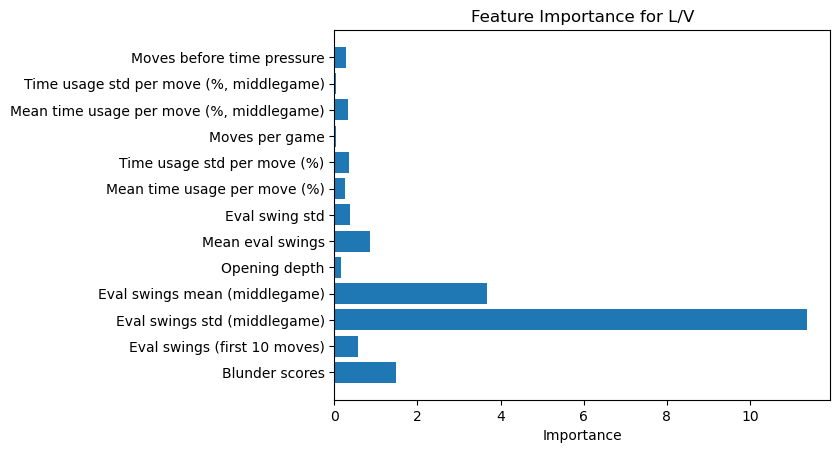

In [29]:
feature_importance = np.mean(np.abs(model_ova.coef_), axis=0) ## Generate a list of feature importance.
plt.barh(scaled_data.columns, feature_importance) ## Next, we plot it as a horizontal bar chart.
plt.title("Feature Importance for L/V")
plt.xlabel("Importance")
plt.show()

## As we remember from the criteria list, it was indeed evaluation swing std and mean that determined the L/V MBTI letter.
### This means that model correctly evaluated the two most important metrics here, it also considers other metrics, but they matter much less.
### Before me move on, it is crucial to understand that an accuracy of 85% doesn't signal a bad understanding of the model necessarily.
### On the contrary, it might also be a good sign, because it shows that the model considers the whole spectrum of given data to make it's decision.

## Now we move on to a technique called **k-NN neighbors**.
### You can interpret this technique to plot the data entries on a 2D plane and look at k points that are the closest to it.
### After that, it bases it's decision on which category these neighbors belong to. 

In [30]:
for k in range(1, 21):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_model = knn_classifier.fit(X1_train,Y1_train)
    Y1_hat = knn_model.predict(X1_test)
    print(f'Test set accuracy for k = {k} = {accuracy_score(Y1_test, Y1_hat)*100}%')


Test set accuracy for k = 1 = 90.54054054054053
Test set accuracy for k = 2 = 89.4894894894895
Test set accuracy for k = 3 = 91.44144144144144
Test set accuracy for k = 4 = 90.54054054054053
Test set accuracy for k = 5 = 92.64264264264264
Test set accuracy for k = 6 = 90.990990990991
Test set accuracy for k = 7 = 91.14114114114115
Test set accuracy for k = 8 = 90.69069069069069
Test set accuracy for k = 9 = 90.84084084084084
Test set accuracy for k = 10 = 90.09009009009009
Test set accuracy for k = 11 = 90.69069069069069
Test set accuracy for k = 12 = 90.09009009009009
Test set accuracy for k = 13 = 90.990990990991
Test set accuracy for k = 14 = 90.39039039039038
Test set accuracy for k = 15 = 90.54054054054053
Test set accuracy for k = 16 = 90.69069069069069
Test set accuracy for k = 17 = 90.84084084084084
Test set accuracy for k = 18 = 90.69069069069069
Test set accuracy for k = 19 = 90.54054054054053
Test set accuracy for k = 20 = 90.69069069069069


### Overall, k-NN also showed a great precision, ranging from 89.5 to 92.6%, a great candidate.

## Next up is a technique called **decision tree**.

In [34]:
rf1 = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
rf1.fit(X1N_train, Y1N_train)
Y1_hat = rf1.predict(X1N_test)
print(f'Test set accuracy = {accuracy_score(Y1N_test, Y1_hat)}')

Test set accuracy = 0.9669669669669669


In [35]:
rf2 = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
rf2.fit(X2N_train, Y2N_train)
Y2_hat = rf2.predict(X2N_test)
print(f'Test set accuracy = {accuracy_score(Y2N_test, Y2_hat)}')

Test set accuracy = 0.9534534534534534


In [36]:
rf3 = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
rf3.fit(X3N_train, Y3N_train)
Y3_hat = rf3.predict(X3N_test)
print(f'Test set accuracy = {accuracy_score(Y3N_test, Y3_hat)}')

Test set accuracy = 0.8858858858858859


In [37]:
rf4 = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
rf4.fit(X4N_train, Y4N_train)
Y4_hat = rf4.predict(X4N_test)
print(f'Test set accuracy = {accuracy_score(Y4N_test, Y4_hat)}')

Test set accuracy = 0.9714714714714715


### We can already see that it shows magnificent understanding just by looking at the accuracy: 88, 95, 96 and 97%. 
### But it's not even it's best feature. To see what it is, just run the next cell.

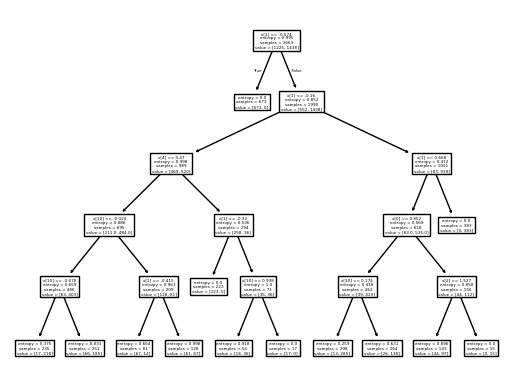

In [38]:
plot_tree(rf3)
plt.show()

## Yes, after training the decision tree, you can easily plot it, which is like looking into the thought process of the model.
### This feature is not unique to the decision tree, but it's a massive advantage as you can peek into the logic of the choice.

## After looking at the decision tree, it makes sense to continue with an 'upgrade' in **Random Forest** technique.
### Random Forest improves on decision tree by randomly creating decision trees using random subsets.
### Then the outputs of these trees are aggregated to improve the accuracy of the resulting model.

In [34]:
RFC1 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=7)
RFC1.fit(X1_train, Y1_train)
YhatGS1 = RFC1.predict(X1_test)
print(accuracy_score(YhatGS1, Y1_test))
RFC2 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
RFC2.fit(X2_train, Y2_train)
YhatGS2 = RFC2.predict(X2_test)
print(accuracy_score(YhatGS2, Y2_test))
RFC3 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
RFC3.fit(X3_train, Y3_train)
YhatGS3 = RFC3.predict(X3_test)
print(accuracy_score(YhatGS3, Y3_test))
RFC4 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
RFC4.fit(X4_train, Y4_train)
YhatGS4 = RFC4.predict(X4_test)
print(accuracy_score(YhatGS4, Y4_test))

0.96996996996997
0.9594594594594594
0.9009009009009009
0.972972972972973


## As we can see, there was a boost in accuracy, but since the decision tree was already good, this boost is barely noticeable.
### Still, since we don't lose in terms of speed, Random Forest is a great and overall better option.

## Lastly, let's look at **gradient boosting**.
### To simplify, gradient boosting also builds multiple decision trees, but it's approach later is a bit different.
### It improves by sequentially looking at each tree's mistakes and improves on them during each iteration.

In [36]:
GBC=GradientBoostingClassifier()
GBC.fit(X1_train, Y1_train)
Yhat1 = GBC.predict(X1_test)
print(accuracy_score(Yhat1, Y1_test))
GBC.fit(X2_train, Y2_train)
Yhat2 = GBC.predict(X2_test)
print(accuracy_score(Yhat2, Y2_test))
GBC.fit(X3_train, Y3_train)
Yhat3 = GBC.predict(X3_test)
print(accuracy_score(Yhat3, Y3_test))
GBC.fit(X4_train, Y4_train)
Yhat4 = GBC.predict(X4_test)
print(accuracy_score(Yhat4, Y4_test))

0.9684684684684685
0.948948948948949
0.9009009009009009
0.96996996996997


## Gradient boosting also showed amazing accuracy ranging from 90 to almost 97%.
### In the end, let's go with Random Forest technique as it's a tiny nudge more accurate and quick.

### In the cell below we build 4 separate Random Forest models using something called **grid search**.
### Grid search works by providing a set of different values for different parameters of a model.
### After that, grid search fits each combination of provided parameter grid to find the best one.
## Overall, grid search takes a great amount of time, so feel free to skip this cell and move on to the next ones, where I used the results of the grid search for the final versions of the model.

In [79]:
SC = StandardScaler()
model =RandomForestClassifier()
P_input = [('scaler', SC),('Model', model)]
PL = Pipeline(P_input)

max_depth = [None, 3, 4, 5, 6, 7]
criterion=['gini', 'entropy', 'log_loss']
max_features=['sqrt', 'log2', None]
k_fold = StratifiedKFold(n_splits = 4,shuffle=True, random_state=42)
parameters = dict(Model__max_depth=max_depth,Model__criterion=criterion, Model__max_features=max_features)

Model1 = GridSearchCV(PL, parameters, cv=k_fold)
Model2 = GridSearchCV(PL, parameters, cv=k_fold)
Model3 = GridSearchCV(PL, parameters, cv=k_fold)
Model4 = GridSearchCV(PL, parameters, cv=k_fold)

Model1.fit(X1_train, Y1_train)
Model2.fit(X2_train, Y2_train)
Model3.fit(X3_train, Y3_train)
Model4.fit(X4_train, Y4_train)

Yhat1 = Model1.predict(X1_test)
Yhat2 = Model2.predict(X2_test)
Yhat3 = Model3.predict(X3_test)
Yhat4 = Model4.predict(X4_test)

print(Model1.best_params_, accuracy_score(Yhat1, Y1_test))
print(Model2.best_params_, accuracy_score(Yhat2, Y2_test))
print(Model3.best_params_, accuracy_score(Yhat3, Y3_test))
print(Model4.best_params_, accuracy_score(Yhat4, Y4_test))

{'Model__criterion': 'entropy', 'Model__max_depth': 7, 'Model__max_features': None} 0.96996996996997
{'Model__criterion': 'entropy', 'Model__max_depth': None, 'Model__max_features': None} 0.9519519519519519
{'Model__criterion': 'entropy', 'Model__max_depth': None, 'Model__max_features': None} 0.9039039039039038
{'Model__criterion': 'entropy', 'Model__max_depth': None, 'Model__max_features': None} 0.972972972972973


## Last step of model building - let's run the cell below to initialize our Random Forest models!

In [28]:
M1 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=7)
M1.fit(X1_train, Y1_train)
M2 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
M2.fit(X2_train, Y2_train)
M3 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
M3.fit(X3_train, Y3_train)
M4 = RandomForestClassifier(criterion='entropy', max_features=None, max_depth=None)
M4.fit(X4_train, Y4_train)

RandomForestClassifier(criterion='entropy', max_features=None)

## Now, before the most interesting part I would like to show why we even began to build models rather than simply relying on thresholds.
### To do this, I collected a dataset of a certain player, where the model's predicted type will differ from a type provided by thresholds.

In [59]:
ex_df=pd.read_csv('example_data.csv')
ex_df.drop(columns=['Unnamed: 0'], inplace=True)
Scaler = StandardScaler()
Scaler.fit(data_df)
Scaler.transform(data_df) ## A crucial step - scaling the data just the same way that we did with the original, raw dataset.
T_set = Scaler.transform(ex_df)
ex_df

,Blunder scores,Eval swings (first 10 moves),Eval swings std (middlegame),Eval swings mean (middlegame),Opening depth,Mean eval swings,Eval swing std,Mean time usage per move (%),Time usage std per move (%),Moves per game,"Mean time usage per move (%, middlegame)","Time usage std per move (%, middlegame)",Moves before time pressure
0,0.18605,0.139083,0.757526,0.411031,4.708333,0.497938,1.171753,1.885464,1.885464,52.25,4.645567,5.723093,23.25


In [58]:
result_type=''

for i in [M1, M2, M3, M4]:
    if len(result_type)<4:
        result_type+=str(i.predict(T_set)[0])
print(f'Model prediction: {result_type}, threshold prediction: IGNV')

Model prediction: IGNL, threshold prediction: IGNV


## Now what exactly is special about this particular difference between model prediction and threshold prediction?
## As you can see, the difference is in the L/V parameter, which originally relies on evaluation swing std and blunder scores.
## For this particular player, his evaluation swing std is pretty normal (0.78), however the blunder score of 0.18 is very low.
## Thresholds are not flexible enough to appreciate it, but the model is, which is why it sees past the first criteria.

## Alright, now we can finally move on to the best part - testing Chess MBTI on ourselves, or our friends if you will!
## Simply input your nickname in the cell below, run the next cells and see the results for yourself.
## Thank you in advance for sticking with me until the end, I appreciate it a lot!

In [17]:
nickname = str(input('Type the nickname: '))

Type the nickname:  RomKali


In [18]:
dataset, threshold_type, stage = get_data(nickname)
dataset

,Blunder scores,Eval swings (first 10 moves),Eval swings std (middlegame),Eval swings mean (middlegame),Opening depth,Mean eval swings,Eval swing std,Mean time usage per move (%),Time usage std per move (%),Moves per game,"Mean time usage per move (%, middlegame)","Time usage std per move (%, middlegame)",Moves before time pressure
0,0.233917,0.13925,0.531584,0.319703,6.633333,0.533663,1.309901,2.44604,2.44604,52.25,12.721584,15.06901,16.625


In [29]:
Scaler = StandardScaler()
Scaler.fit(data_df)
Scaler.transform(data_df)
T_set = Scaler.transform(dataset)

In [30]:
result_type=''

for i in [M1, M2, M3, M4]:
    if len(result_type)<4:
        result_type+=str(i.predict(T_set)[0])
print(f'Model prediction: {result_type}, threshold prediction: {threshold_type}')


Model prediction: UGTL, threshold prediction: UGTL


In [31]:
result_dict = os.getenv("results")
type_dict = json.loads(base64.b64decode(result_dict).decode())

In [32]:
print('Test Results:\n')
print(f'Your chess MBTI is {result_type} ({type_dict['6'][result_type]})!\n')
print(f'Here is a short description of your chess MBTI:\n{type_dict['5'][result_type]}\n')
print(f'You should definitely look up games of {type_dict['0'][result_type][0]} and {type_dict['0'][result_type][1]}. Seems like you guys have a lot in common! :)\n')
if stage in ['beginner', 'amateur']:
    print(f'Friendly advice: take up {type_dict['1'][result_type][0][0]} and {type_dict['1'][result_type][0][1]}, gain some free Elo and thank me later!\n')
else:
    print(f'Friendly advice: take up {type_dict['1'][result_type][1][0]} and {type_dict['1'][result_type][1][1]}, gain some free Elo and thank me later!\n')
print(f'Being a {result_type}, your competitive advantages are probably: \n1. {type_dict['2'][result_type][0]} \n2. {type_dict['2'][result_type][1]} \nCherish these traits and capitalize on them!\n')
print(f'On the other hand, be on a look out for:\n1. {type_dict['3'][result_type][0]} \n2. {type_dict['3'][result_type][1]}\nWe can not all be flawless like Magnus. Practice and minimize your disadvantages!\n')
print(f'Main goal of Chess MBTI project is to connect chess players with opponents of MBTIs that click and make chess even more fun and enjoyable!\nSo, being a {result_type}, if your date happens to be a {type_dict['4'][result_type]} - buy them a drink and friend them on lichess right away!')

Test Results:

Your chess MBTI is UGTL (Engineer)!

Here is a short description of your chess MBTI:
You are the Engineer — precise, principled, and methodical.
You favor clear, correct play and navigate the board like a well-designed system, valuing structure and incremental advantage. 
Your calculation is sharp, but always purposeful, and you are happy to outlast your opponent move by move. 
You thrive in openings you have mastered and positions where logic wins the day.

You should definitely look up games of Anish Giri and Anatoly Karpov. Seems like you guys have a lot in common! :)

Friendly advice: take up Exchange QGD/Catalan and Berlin Defense, gain some free Elo and thank me later!

Being a UGTL, your competitive advantages are probably: 
1. Highly accurate and strategic in opening and middlegame transitions, often guiding the game into technical waters. 
2. Comfortable grinding out long endgames with solid positional plans. 
Cherish these traits and capitalize on them!

On the